In [6]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import random
import itertools
from itertools import combinations


import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import pymc as pm
from scipy.special import expit, logit
import pytensor.tensor as pt

import warnings
import pickle
warnings.filterwarnings("ignore", category=FutureWarning)


In [2]:
# versions

print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

pandas==2.0.3
numpy==1.24.2
seaborn==0.12.2
arviz==0.15.1
pymc==5.1.2
daft==0.1.2


## Introduction

This is the notebook that describes how the effect sizes of chauvinism, field and strictness will be calculated and compared for the hypothesis tests. More annotion will be added ASAP.

This is the verbal description of the hypothesis test, as given in the analysis plan:

Most generally, we will compare the effect sizes of the three variables of interest. These effect sizes will be measured using posterior predictive samples. More precisely, we will look at the differences in proportions of ‘binary score = 1’.
To do this, we will use the model described in the attached analysis code to estimate posterior distributions for the strictness of each rater, the chauvinism of each rater, for each field, and for each of the causes. In addition, we will run a separate model to estimate the prevalence of each of the causes in each of the fields. We will use the posteriors from these models to draw posterior predictive samples varying only the variable of interest:

**- Strictness effect size:** posterior predictive samples will be drawn using values drawn randomly from the merged field parameters (so as to avoid field effects), from each of the causes parameters, and from the merged chauvinism parameters (so as to avoid chauvinism effects). We will then draw samples for each of the raters, drawing values from the posterior of their strictness parameter. We will then look at the difference in expected proportions of ‘1’s in these samples between the strictest and the least strict rater for each rater-pair. This gives us an effect size for each rater-pair. These effect sizes will then be pooled to estimate the overall effect size of switching from the strictest to the least strict rater in a rater pair. If this distribution of differences in proportions of ‘1s’ centers around zero, there is no strong reason to believe that there is an effect in either direction.

**- Field effect size:** posterior predictive samples will be drawn using values drawn randomly from the merged chauvinism parameters (so as to avoid effects from these) and from the merged strictness parameters (so as to effects from these). We will then draw samples for each of the fields, drawing values from the posterior of their parameter in the linear model. For each hypothetically sampled paper, the cause-parameters will be switched to ‘1’ or ‘0’ based on the proportions estimated by the separate model ran to estimate cause frequencies by field. We will then look at the difference in expected proportions of ‘1’s in these samples between the field with the highest estimated mean proportion and the lowest estimated mean proportion for all field pairs. This gives us an effect size for each field pair. These effect sizes will then be pooled to estimate the overall effect size of switching from the highest-valued field to the lowest-valued field. If this distribution of differences in proportions of ‘1s’ centers around zero, there is no strong reason to believe that there is an effect in either direction.

**- Chauvinism effect size:** The strategy used for ‘strictness’ and ‘field’ (i.e. looking at the difference in expected proportions of 1s between pairs) will not be used for chauvinism because it is not practically interesting. This is because even if all raters are strongly chauvinistic, the effect size would be 0 if they are equally chauvinistic. This would be problematic because chauvinism would have a large effect, even if everyone is equally chauvinistic, if raters or documents reviewed are from different fields. The interesting contrast here is not between pairs of raters, but between being chauvinistic or not in any particular review. Hence, for the effect size of chauvinism we will for each rater compare the proportions of 1s between chauvinism being switched on for all papers, and chauvinism being switched off for all papers. Hence, posterior predictive samples will be drawn using values drawn randomly from the merged field parameters (so as to avoid field effects), from each of the causes parameters, and from the merged strictness parameters (so as to avoid strictness effects). We will then draw samples for each of the raters, drawing values from the posterior of their strictness parameter. We do this once with their chauvinism parameter switched on for all ratings, drawing samples from the posteriors of their chauvinism parameters; and once with their chauvinism parameters set to 0 for all ratings. We will then look at the difference in expected proportions of ‘1’s between these samples. This gives us an effect size for each rater. These effect sizes will then be pooled to estimate the overall effect size of being chauvinistic in a rating vs. not being chauvinistic. If this distribution of differences in proportions of ‘1s’ centers around zero, there is no strong reason to believe that there is an effect in either direction.

Having estimated the effect size of chauvinism, strictness and field in the way described above, we will then subtract these distributions from each other to estimate the difference in effect size. More precisely:

1) To compare the effect of strictness and field, we will subtract the field effect size from the strictness effect size. The resulting distribution represents the estimated difference in effect size between the two. We expect these values to be positive. A distribution of largely negative values or with zero in the center would go against our hypothesis.

2) To compare the effect of chauvinism and field, we will subtract the field effect size from the chauvinism effect size. The resulting distribution represents the estimated difference in effect size between the two. We expect these values to be positive. A distribution of largely negative values or with zero in the center would go against our hypothesis.

Note that we do not preregister a binary rule (e.g. a certain HDI of the difference in effect size that must not contain zero) to reject or accept the hypothesis. This would be arbitrary and there is no immediate practical use of such a decision rule. Instead, we will report the estimated differences in effect sizes and let readers decide whether the results are strong enough to reject or accept the hypothesis. We will, however, state whether the difference in effect sizes is in line with our expectations (most probability mass above zero) or against our expectations (most probability mass below zero).

Any changes to the code (due to unforeseen changes) will be documented and highlighted in new versions of the notebooks posted after finishing data-collection and analysis.


# Data

In [3]:
## the dataset

df = pd.read_csv("...")
df = df.drop(['Unnamed: 0'], axis=1)

# select which group

df = df.loc[df.group == 'group1']

# put in the right order
df = df.sort_values(by = ['block','field','rater'])



# for tests, check how many raters and blocks you want

# test_nblocks = 69
# random_blocks = np.random.choice(df.block.unique(), test_nblocks, replace = False)

# test_nraters = 2
# random_raters = np.random.choice(df.rater.unique(), test_nraters, replace = False)

# df = df.loc[(df.block.isin(random_blocks)) & (df.rater.isin(random_raters))]


# dtype should be categorical

cat_cols = ['block', 'field', 'rater', 'binary', 'abstract','ordinal', 
            'rater_disc', 'doctype', 'group','chauvinism']

df[cat_cols] = df[cat_cols].astype('category')



In [4]:
## get the model results from the netcdf file
## For how these were generated, see: IIH_model_preregistration.ipynb

trace_test = az.from_netcdf("...")

# Field effect size

In [5]:
""" 
get estimates of how much each of the code causes occurs in each field
this we can then use to get posterior predictive samples from our main model
this is necessary because there is no parameter for field overall, so we need to know how much of each causes parameter to add in for each field
because certain combos occur more than others, we don't simply use cause per field, but 'combination of 7 causes' per field 

"""


# note: if there is only one group, no need to combine and use 'df_short' instead of 'df_shortall' (which will be the case for the follow-up study)

df_shortall = pd.read_csv(r'C:\Users\conix\Dropbox\aWriting\humanities impact\data\IIH_all_data')
df_shortall = df_shortall.drop(['Unnamed: 0'], axis=1)

causes = ['Present','Intolerance','Ethics','Empirical','Environment','Education','Wellbeing']

# limit to one rater for each group, as all we need is the frequency of codes per paper

df_shortall = df_shortall.loc[df_shortall.rater.isin([521,342])]

# make column with code combo as value

df_shortall['array'] = [str(df_shortall[causes].iloc[i,:].values) for i in range(len(df_shortall))]

# limit to the columns of code-combos and field
causes_freq = df_shortall[['array','field']].copy()
causes_freq = causes_freq.astype('string')

# combine field and code combo, as we need to model the frequency of combinations per field 
causes_freq['combined'] = causes_freq['field'] + '_' + (causes_freq["array"])

# one hot encode and stack
causes_freq = pd.get_dummies(data = causes_freq, columns = ['combined'], dtype = int)
causes_freq = causes_freq.iloc[:,2:].stack().reset_index()
causes_freq['level_1'] = causes_freq['level_1'].astype('category')
causes_freq.rename(columns = {0:'observed','level_1':'field_cause_combo'}, inplace = True)

# get categories for the model
group_codes = causes_freq['field_cause_combo'].cat.categories.values
coords = {'g_n': group_codes }

# model the frequencies of the code combos

with pm.Model(coords=coords) as m_causes:
    
    GROUP = pm.MutableData('GROUP',causes_freq['field_cause_combo'].cat.codes.values)
    
    p = pm.Normal('p',0,5, dims = 'g_n')
    y = pm.Bernoulli('y', logit_p = p[GROUP], observed = causes_freq['observed'].values)
    trace_causes = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1102 seconds.


In [7]:
# get the posteriors for each of the code-combos for each of the fields

code_counts = [trace_causes.posterior['g_n'].values[i].split('_')[1] for i in range(len(trace_causes.posterior['g_n'].values))]

# count the number of code-combinations per field, and use that to get the right group of posteriors for each field

h_c = code_counts.count('HIST')
l_c = code_counts.count('LING')
lit_c = code_counts.count('LIT')
p_c = code_counts.count('PHIL')
r_c = code_counts.count('REL')

trace_hist = az.extract_dataset(trace_causes.posterior['p'][:,:,:h_c], combined = True)
trace_ling = az.extract_dataset(trace_causes.posterior['p'][:,:,h_c:h_c+l_c], combined = True)
trace_lit = az.extract_dataset(trace_causes.posterior['p'][:,:,h_c+l_c:h_c+l_c+lit_c], combined = True)
trace_phil = az.extract_dataset(trace_causes.posterior['p'][:,:,h_c+l_c+lit_c:h_c+l_c+lit_c+p_c], combined = True)
trace_rel = az.extract_dataset(trace_causes.posterior['p'][:,:,len(code_counts) - r_c:], combined = True)

traces = [trace_hist, trace_ling, trace_lit, trace_phil, trace_rel]

# choose number of ppc samples
n_ppc = 100000

# samples values from the posteriors of the causes parameters (causes params has all non-field causes)

causes_params = az.extract_dataset(trace_test.posterior['causes'],  combined = True)['causes'][:, np.random.randint(0,trace_test.posterior['causes'].shape[1], size = n_ppc)]
fieldsigma_params = az.extract_dataset(trace_test.posterior['field_sigma'], combined = True)['field_sigma'].values

# loop over the fields, and get values for each field, combining:
# 1) the parameter for that field
# 2) the probabilities of getting certain codes-combos
# 3) the parameters for the causes (multiplied by the code combo)
# then just make the sum of the linear model: sum all causes with the field

ppc_fields = {} # dict with for each field arrays of 1s and 0s that are the ppc samples.
causes_fields = {} # dict with the causes-arrays by field

for i in range(5):

    causes_probs = expit(traces[i]['p'][:, np.random.randint(0,traces[i]['p'].shape[1], size=n_ppc)])*5
    causes_probs = causes_probs / causes_probs.sum(axis = 0)
    
    # get code combos for that field
    
    dct = {}
    n_codes = len(traces[i]['g_n'].values)
    for j in range(n_codes):
        
        # this unelegant splitting operation is to turn the string-combo of codes back into an array of 1s and 0s for the causes
        dct[j] = np.array(list(map(int,traces[i]['g_n'].values[j].split('_')[2].split('[')[1].split(']')[0].split('.')[:-1]))) 
        
    # now get an array of the sampled code-combos for that field

    code_combos = [np.random.choice(np.arange(n_codes), p = k) for k in causes_probs.values.T]
    causes_data = np.array([dct[l] for l in code_combos])
    causes_fields[trace_test.posterior['f_n'].values[i]] = causes_data
    
    # now multiply the causes-parameter values by the 1's and 0's that indicate whether they are present
    causes_finished_array = (causes_params * causes_data.T).sum(axis = 0).values
    
    # sum the causes data with the field parameter and store in the ppc_fields dict
    lm = (causes_finished_array + np.random.choice(np.ravel(trace_test.posterior['field'][:,:,i].values),n_ppc, replace = True))
    sigma_sample = np.random.choice(fieldsigma_params[i,:], size = n_ppc, replace=True)
    result = np.random.normal(lm, sigma_sample)
    ppc_fields[trace_test.posterior['f_n'].values[i]] = result
    
    

In [8]:
# run the posterior predictive paper_values for each field through the rating procedure, and see if we get the same number of 1's and 0's
# which strictness values and chauvinism values to use? I'll sample randomly from all raters, and will use a chauvinism-value > 0 for 20% of the papers

n_sample = 69
samples = 1000
chauvinism_posterior = az.extract_dataset(trace_test.posterior['chauvinism'], group = 'posterior', combined = True)
strictness_posterior = az.extract_dataset(trace_test.posterior['strictness'], group = 'posterior', combined = True)


# because this is about field, we keep rater characteristics the same
# hence: throw the posterior values for all raters together, and draw randomly from that

chauvinism_merged = np.ravel(chauvinism_posterior['chauvinism'].values)
strictness_merged = np.ravel(strictness_posterior['strictness'].values)

# sample with random index arrays instead of np.random.sample so that if we want to separate raters and do the sampling vectorized we don't have to change the code
# keep chauvinism and strictness the same within each sample, in line with our model

idx_chauv = np.random.randint(0,len(chauvinism_merged), n_sample) # index array to sample from chauvinism
zeros_chauv = np.random.choice([0,1], p = [0.8,0.2], size = n_sample) # chauvinism only applies in 20% of the papers
idx_strictness = np.random.randint(0,len(strictness_merged), n_sample) # index array to sample from the strictness parameter

chauv_param = chauvinism_merged[idx_chauv] * zeros_chauv
strictness_param = strictness_merged[idx_strictness]

binary_results = {} # dct to store the binary outcomes for each sample

for i in trace_test.posterior['f_n'].values: # loop over fields
    s = []
    for j in range(samples):
        
        # in line with our model, the bernoulli get's fed the estimated paper size + chauvinism when it applies + strictness
        vals = np.random.choice(ppc_fields[i], size = n_sample, replace = True) + strictness_param + chauv_param
        
        # bernoulli trials, expit for the transform
        s.append(np.random.binomial(1, p = expit(vals)))
        
    binary_results[i] = np.array(s)

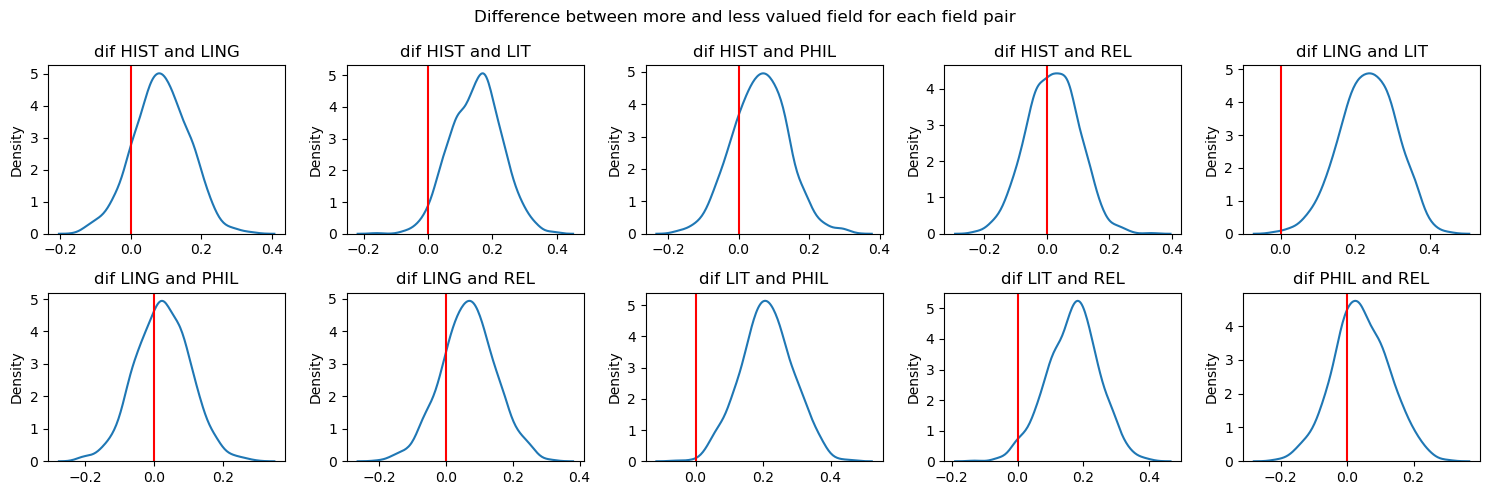

In [9]:
# now get the effect size

fields = list(binary_results.keys()) # field names as stored by the model

field_effect_sizes = {} # dct for storing the effect size for each field pair

fig, axs = plt.subplots(2,5,figsize = (15,5))

for ax,i in zip(axs.flat, combinations(range(5),2)):
    
    # get the proportions of 1s in each of the ppc samples for each pair of fields
    field_a = binary_results[fields[i[0]]].mean(axis = 1)
    field_b = binary_results[fields[i[1]]].mean(axis = 1)
    
    # subtract the smaller from the larger
    # question: should we use mean here, or something else?
    
    if field_a.mean() > field_b.mean():
        dif = field_a - field_b
    else:
        dif = field_b - field_a
        
    # store and plot
    
    field_effect_sizes[f'dif_{i}'] = dif
    sns.kdeplot(dif, ax=ax)

    ax.set_title(f'dif {fields[i[0]]} and {fields[i[1]]}')
    ax.axvline(0, color = 'r')

plt.suptitle('Difference between more and less valued field for each field pair')
fig.tight_layout()

# Chauvinism effect size

In [13]:
# get posterior distributions for the three relevant variables

paper_values_posterior = az.extract_dataset(trace_test.posterior['paper_value'], group = 'posterior', combined = True)
chauvinism_posterior = az.extract_dataset(trace_test.posterior['chauvinism'], group = 'posterior', combined = True)
strictness_posterior = az.extract_dataset(trace_test.posterior['strictness'], group = 'posterior', combined = True)

# choose number of posterior predictive samples

size = 1000

# get chauvinism and strictness samples outside of the loop for speed purposes


chauv_samples = chauvinism_posterior['chauvinism'][:, np.random.randint(0,chauvinism_posterior['chauvinism'].shape[1], size=size)]
strictness_samples = strictness_posterior['strictness'][:, np.random.randint(0,strictness_posterior['strictness'].shape[1], size=size)]

# dcts to save proportions in

ppc_chauvinism = {}
ppc_no_chauvinism = {}

# loop over raters, and get samples for with and without chauvinism for each rater
n_raters = len(df.rater.unique())

for i in range(n_raters):

    # randomly sample complete samples (i.e. 69 sets of 5 papers) from the posteriors of our papers
    
    paper_vals = paper_values_posterior['paper_value'][:,:,np.random.randint(0,paper_values_posterior['paper_value'].shape[1], size=size)]

    # get the random samples of chauvinism and strictness for the particular raters
    
    rater_chauv = chauv_samples[i,:].values
    rater_strictness = strictness_samples[i,:].values
    
    # like in the model, the estimate is the sum of the paper_value and the chauvinism; here we use samples from the posterior
    
    paper_est_chauv = paper_vals.values + rater_chauv
    
    # the binary score is on the basis of paper_estimate + strictness, which determines the probability of scoring "1"
    # first with chauvinism switched on
    
    paper_probs_chauv = expit(paper_est_chauv + rater_strictness)
    result_chauv = np.random.binomial(1, paper_probs_chauv)
    ppc_chauvinism[f'rater_{i}'] = result_chauv
    
    # then without chauvinism

    paper_est_nochauv = paper_vals.values
    paper_probs_nochauv = expit(paper_est_nochauv + rater_strictness)
    result_nochauv = np.random.binomial(1, paper_probs_nochauv)
    ppc_no_chauvinism[f'rater_{i}'] = result_nochauv


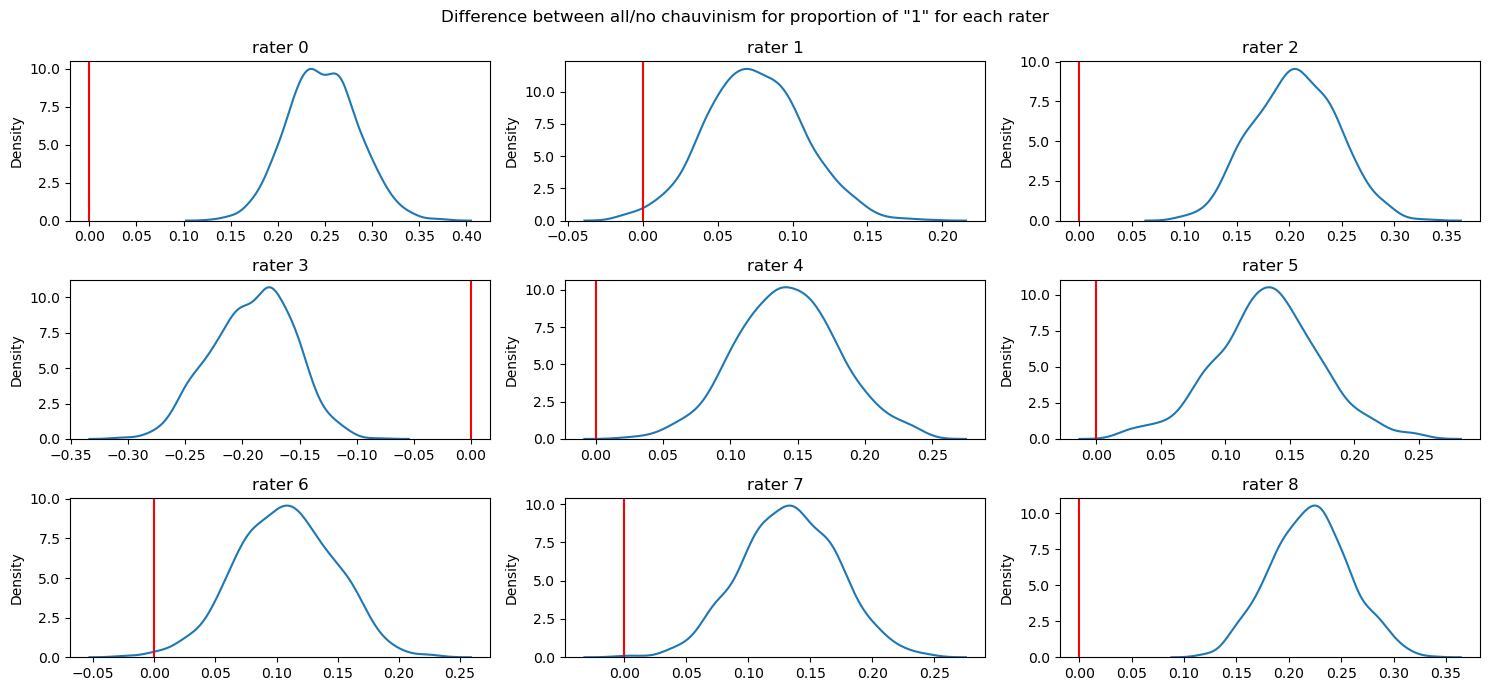

In [16]:

# plot the difference between chauvinism and not chauvinism
# looks like chauvinism makes a difference in proportion between 0.10 and 0.25
# get this for each combo of raters, not just for one vs all!!!


fig, axs = plt.subplots(3,3, figsize = (15,7))

chauv_effect_sizes = {} # store the effect sizes here

n_samples = 1000
for ax,i in zip(axs.flat, range(len(df.rater.unique()))):
    chauv = ppc_chauvinism[f'rater_{i}'].reshape((69*5),n_samples).mean(axis = 0)
    no_chauv = ppc_no_chauvinism[f'rater_{i}'].reshape((69*5),n_samples).mean(axis = 0)
    
    # check if the mean of the subtraction is negative
    # if so, for storing effect size, negate the result; the direction of effect is not important here, and for effect size they should all be positive or all negative to be comparable
    
    if (chauv-no_chauv).mean() > 0:
        chauv_effect_sizes[f'rater_{i}'] = chauv - no_chauv
    else:
        chauv_effect_sizes[f'rater_{i}'] = -(chauv - no_chauv)
        
    sns.kdeplot(chauv-no_chauv, ax=ax)

    ax.set_title(f'rater {i}')
    ax.axvline(0, color = 'r')

plt.suptitle('Difference between all/no chauvinism for proportion of "1" for each rater')

fig.tight_layout()
plt.show()

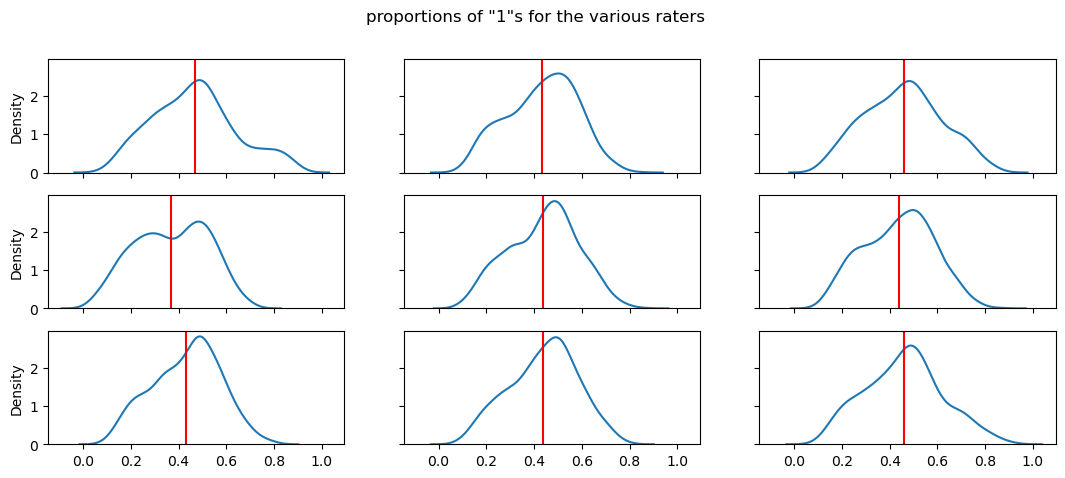

In [18]:
""" 

ALTERNATIVE METHOD: EQUIVALENT TO STRICTNESS ETC
Don't think this is interesting or needed, but put it here for comparison 
This will NOT be used for the hypothesis test

"""


# get posterior distributions for the three relevant variables
# for strictness, get the difference between each pair of rater, drawing random chauvinism samples for across raters

paper_values_posterior = az.extract_dataset(trace_test.posterior['paper_value'], group = 'posterior', combined = True)

chauvinism_posterior = az.extract_dataset(trace_test.posterior['chauvinism'], group = 'posterior', combined = True)

strictness_posterior = az.extract_dataset(trace_test.posterior['strictness'], group = 'posterior', combined = True)
merged_strictness = np.ravel(strictness_posterior['strictness'].values)


# choose number of posterior predictive samples

size = 1000

# get chauvinism and strictness samples outside of the loop
# sample from chauvinism using a random index array because np.random.choice doesn't work with 2d arrays
# strictness should be the same for all samples, so just sample from the merged posteriors of all raters

strictness_samples = np.random.choice(merged_strictness, size = size, replace=True)

chauv_samples = chauvinism_posterior['chauvinism'][:, np.random.randint(0,chauvinism_posterior['chauvinism'].shape[1], size=size)]
# chauvinism applies only to 20% in our sample; change proportions if you want a different kind of comparison (100% might make more sense)
chauv_zeros = np.random.choice([0,1], p = [0.8,0.2], size=chauv_samples.shape)
chauv_vals = chauv_samples * chauv_zeros


ppc_chauv2 = {} # dcts to save the samples in


# loop over raters, and get samples for with and without chauvinism for each rater

n_raters = len(df.rater.unique())

for i in range(n_raters):

    # randomly sample complete samples (i.e. sets of 5 papers) from the posteriors of our papers
    
    paper_vals = paper_values_posterior['paper_value'][:,:,np.random.randint(0,paper_values_posterior['paper_value'].shape[1], size=size)]

    # get the random samples of chauvinism for the particular raters

    rater_chauv = chauv_vals[i,:].values
    
    # like in the model, the estimate is the sum of the paper_value and the chauvinism; here we use samples from the posterior
    
    paper_est = paper_vals.values + rater_chauv
    
    # the binary score is on the basis of paper_estimate + strictness, which determines the probability of scoring "1"
    
    paper_probs = expit(paper_est + strictness_samples)
    result = np.random.binomial(1, paper_probs)
    ppc_chauv2[f'rater_{i}'] = result
    
fig, axs = plt.subplots(3,3,figsize = (13,5), sharex = True, sharey = True)

for ax, i in zip(axs.flat, ppc_chauv2.values()):
    # reshape the samples because fields can be merged
    sns.kdeplot((i.reshape(n_sample*5, size).mean(axis = 0)), ax=ax)
    ax.axvline((i.reshape(n_sample*5, size).mean(axis = 0)).mean(), color = 'r')
    
plt.suptitle('proportions of "1"s for the various raters')
plt.show()


# Strictness effect size


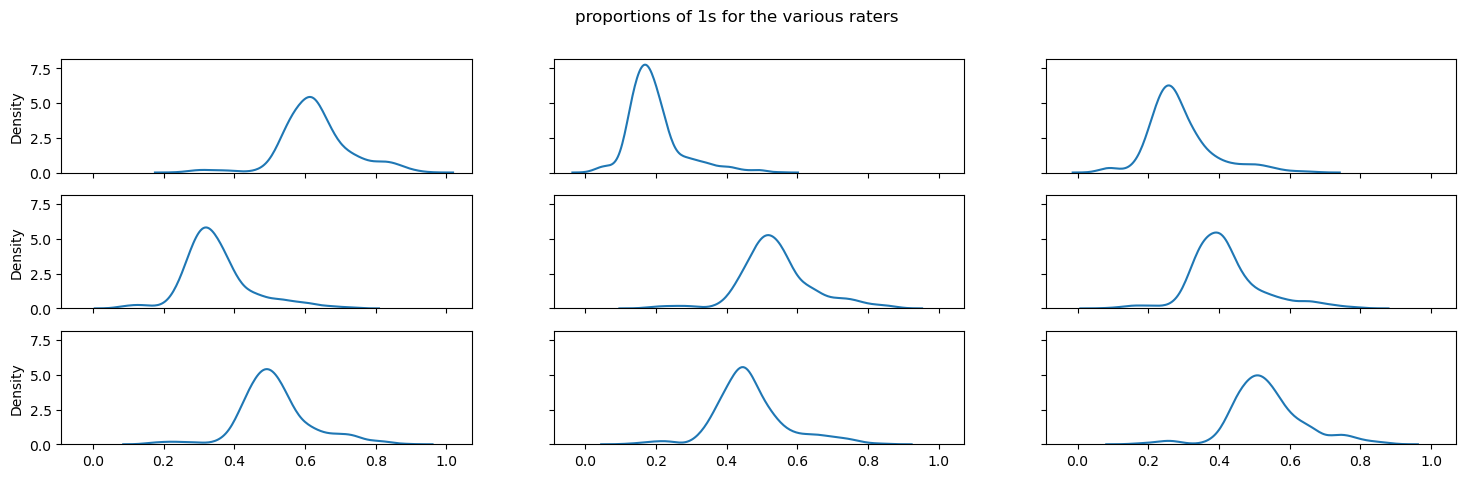

In [20]:
# get posterior distributions for the three relevant variables
# for strictness, get the difference between each pair of rater

paper_values_posterior = az.extract_dataset(trace_test.posterior['paper_value'], group = 'posterior', combined = True)
strictness_posterior = az.extract_dataset(trace_test.posterior['strictness'], group = 'posterior', combined = True)

# for chauvinism, merge because we should decouple strictness and chauvinism
# just draw random chauvinism samples from across raters
chauvinism_posterior = az.extract_dataset(trace_test.posterior['chauvinism'], group = 'posterior', combined = True)
merged_chauvinism = np.ravel(chauvinism_posterior['chauvinism'].values)


# choose number of posterior predictive samples

size = 1000

# get chauvinism and strictness samples outside of the loop
# use index arrays to make vectorized random sampling possible

chauv_samples = np.random.choice(merged_chauvinism, size = size, replace=True)
# apply chauvinism only in 20% of the papers
chauv_zeros = np.random.choice([0,1], p = [0.8,0.2], size=size)
chauv_vals = chauv_samples * chauv_zeros

strictness_rndidx = np.random.randint(0,strictness_posterior['strictness'].shape[1], size=size)
strictness_samples = strictness_posterior['strictness'][:, strictness_rndidx]


ppc_strictness = {} # dcts to save the samples in

# loop over raters

n_raters = len(df.rater.unique())

for i in range(n_raters):

    # randomly sample complete samples (i.e. sets of 5 papers) from the posteriors of our papers
    
    paper_val_rndidx = np.random.randint(0,paper_values_posterior['paper_value'].shape[1], size=size)
    paper_vals = paper_values_posterior['paper_value'][:,:,paper_val_rndidx]

    # get the random samples of chauvinism and strictness for the particular raters

    rater_strictness = strictness_samples[i,:].values
    
    # like in the model, the estimate is the sum of the paper_value and the chauvinism; here we use samples from the posterior
    
    paper_est = paper_vals.values + chauv_vals
    
    # the binary score is on the basis of paper_estimate + strictness, which determines the probability of scoring "1"
    
    paper_probs = expit(paper_est + rater_strictness)
    result = np.random.binomial(1, paper_probs)
    ppc_strictness[f'rater_{i}'] = result
    
fig, axs = plt.subplots(3,3,figsize = (18,5), sharex = True, sharey = True)

for ax, i in zip(axs.flat, ppc_strictness.values()):
    sns.kdeplot((i.reshape(n_sample*5, size).mean(axis = 0)), ax=ax)

plt.suptitle('proportions of 1s for the various raters')
plt.show()

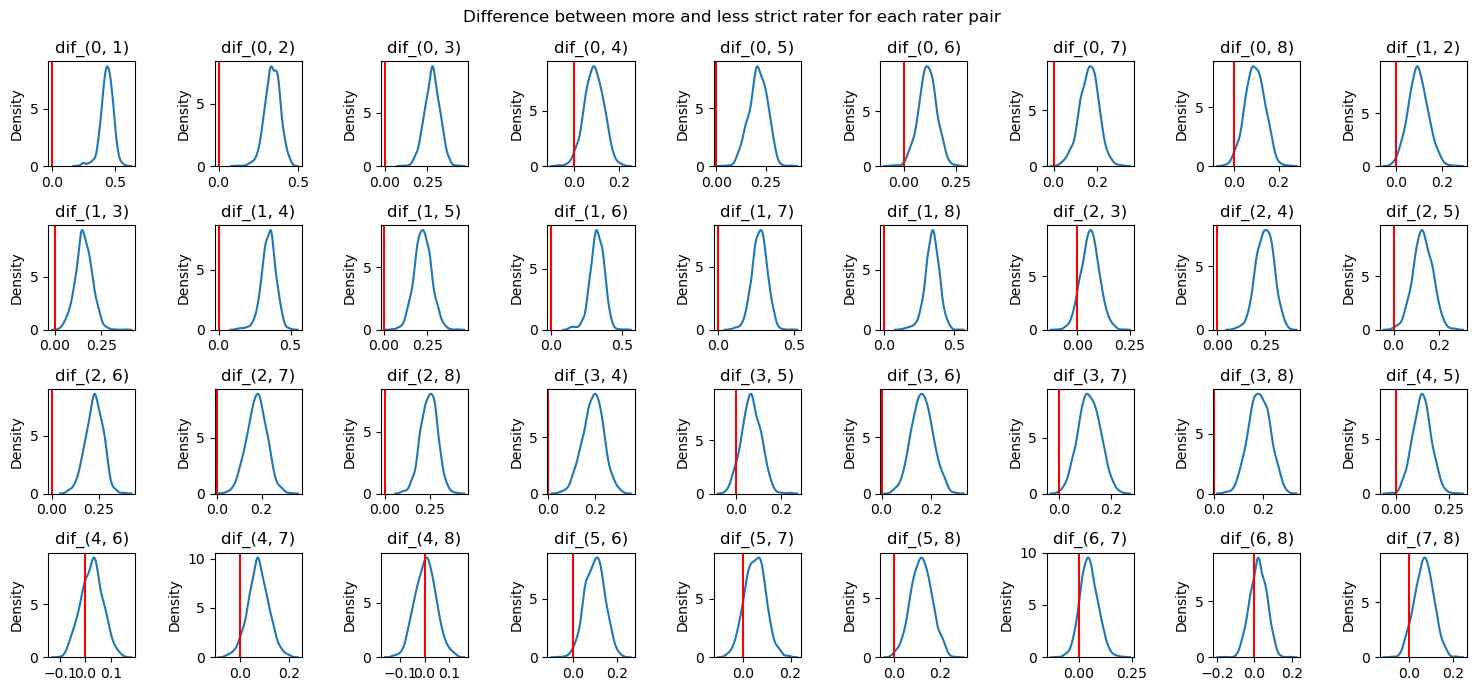

In [22]:
# calculate, plot and store effect sizes for strictness

fig, axs = plt.subplots(4,9, figsize = (15,7))

strictness_effect_sizes = {} # save the difference in proportion of 1s for the strictest minus the least strict rater
n_samples = 1000

# for each unique combo of raters, subtract the proportion of 1s of the least strict from the proportions of 1s of the strictest of the pair

for ax,i in zip(axs.flat, combinations(range(n_raters),2)):
                
    # get a distribution of proportions of 1s for both raters in the pair
    
    strictness_a = ppc_strictness[f'rater_{i[0]}'].reshape(n_sample*5, size).mean(axis = 0)
    strictness_b = ppc_strictness[f'rater_{i[1]}'].reshape(n_sample*5, size).mean(axis = 0)
                
    # subtract least strict from strictest
    
    if strictness_a.mean() > strictness_b.mean():
        dif = strictness_a - strictness_b
    else:
        dif = strictness_b - strictness_a
    
    # store and plot
    
    strictness_effect_sizes[f'dif_{i}'] = dif
    sns.kdeplot(dif, ax=ax)

    ax.set_title(f'dif_{i}')
    ax.axvline(0, color = 'r')

plt.suptitle('Difference between more and less strict rater for each rater pair')

fig.tight_layout()
plt.show()

# Compare effect sizes


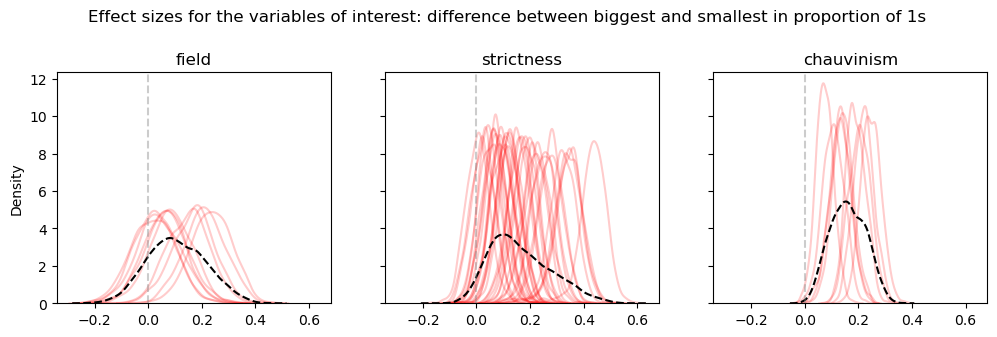

In [26]:
"""
For each of the three variables, plot the effect sizes of all the pairs (or raters, in chauvinism case), and plot them along with the concatenated effect sizes
This density plot of all effect sizes in one array should be a fair representation of the uncertainty we have.

"""

fig, ax = plt.subplots(ncols = 3, figsize = (12,3), sharey = True, sharex = True)

effect_sizes = [ field_effect_sizes,strictness_effect_sizes, chauv_effect_sizes]
effect_sizes_titles = ['field','strictness','chauvinism']

for h, j in zip(range(3), effect_sizes):
    
    # plot each separate effect size
    for i in j.values():
        sns.kdeplot(i, color = 'r', alpha = 0.2, ax=ax[h])
        
    # plot the merged effect sizes
    sns.kdeplot(np.ravel([i for i in j.values()]), linestyle = '--', color = 'black', ax=ax[h])
    
    ax[h].set_title(effect_sizes_titles[h])
    ax[h].axvline(0, color = 'grey', linestyle = '--', alpha = 0.4)
    
plt.suptitle('Effect sizes for the variables of interest: difference between biggest and smallest in proportion of 1s', y = 1.09)
plt.show()



The cell below calculates and shows the differences in effect sizes that we will report, and that constitute the hypothesis tests. As stated in the preregistration, we will not report a particular binary acceptance or rejection. Rather, we will report these figures, along with stating whether it was:

- in line with our expectations (positive mean, and zero is outside the 30% hdi)
- not in line with our expectations (negative mean or zero is outside the 30% hdi)

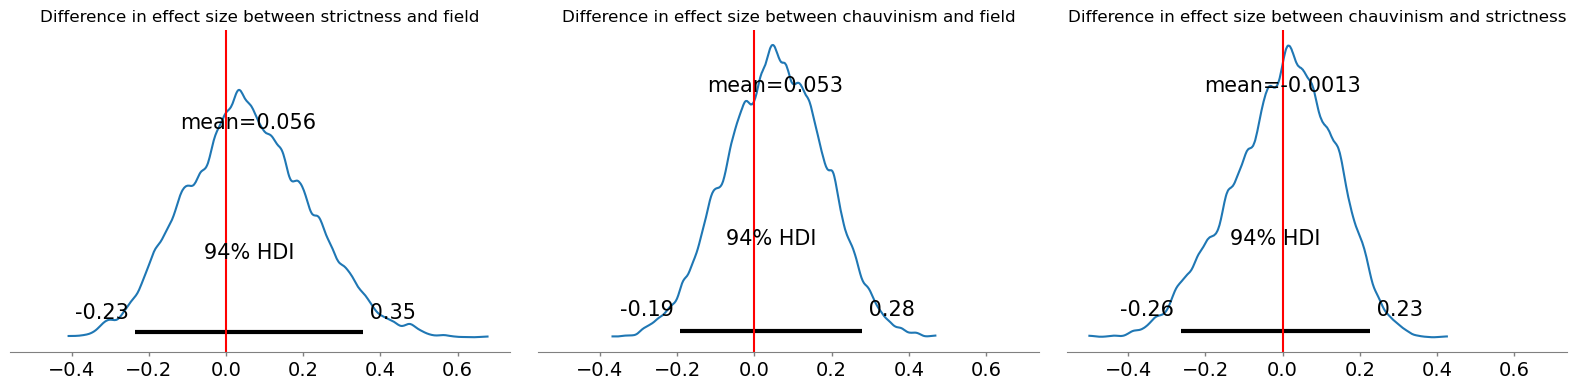

In [28]:
# Difference in effect sizes between variable

fig, ax = plt.subplots(ncols = 3, figsize = (16,4), sharey = True, sharex = True)
n = 10000

# calculate the overall effect size for each
# draw randomly from the concatenated arrays because they have different sizes (and hence cannot be subtracted)

field_overall_effect_size = np.random.choice(
    np.ravel([i for i in field_effect_sizes.values()]),
    n,replace = True)

chauv_overall_effect_size = np.random.choice(
    np.ravel([i for i in chauv_effect_sizes.values()]),
    n,replace = True)

strictness_overall_effect_size = np.random.choice(
    np.ravel([i for i in strictness_effect_sizes.values()]),
    n,replace = True)

# plot the densityplot along with the 94% hdi


for i,j in zip(range(2), effect_sizes[1:]):
    effect_size = np.random.choice(np.ravel([i for i in j.values()]),
                                   n, replace = True)
    az.plot_posterior(effect_size- field_overall_effect_size, ax = ax[i])
    ax[i].set_title(f'Difference in effect size between {effect_sizes_titles[1:][i]} and field')
    ax[i].axvline(0, color = 'r')
    

az.plot_posterior(chauv_overall_effect_size- strictness_overall_effect_size, ax = ax[2])
ax[2].set_title(f'Difference in effect size between chauvinism and strictness')
ax[2].axvline(0, color = 'r')
fig.tight_layout()